In [47]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from IPython.core.pylabtools import figsize
figsize(16, 6)

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [34]:
def sum_of_sines(number_of_steps, d_theta, skip_steps, freqs, amps, phases):
    """
    Add together multiple sine waves and return
    a list of values that is number_of_steps long.
    d_theta is the step (in radians) between samples.
    skip_steps determines the start of the sequence.
    The lists freqs, amps, and phases should all be
    the same length (but we don′t check!)
    """
    values = []
    for step_num in range(number_of_steps):
        angle = d_theta * (step_num + skip_steps)
        sum = 0
        for wave in range(len(freqs)):
            y = amps[wave] * math.sin(
            freqs[wave]*(phases[wave] + angle))
            sum += y
        values.append(sum)
    return np.array(values)

In [35]:
train_sequence_1 = sum_of_sines(200, 0.057, 0, [1, 2], [1, 2], [0, 0])
test_sequence_1 = sum_of_sines(200, 0.057, 400, [1, 2], [1, 2], [0, 0])

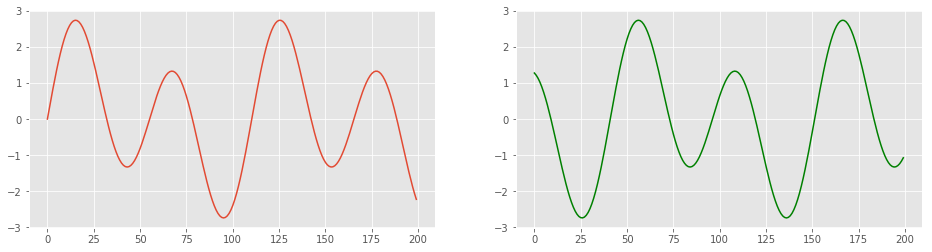

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(train_sequence_1)
ax[1].plot(test_sequence_1, color='green')
plt.show()

In [37]:
train_sequence_2 = sum_of_sines(200, 0.057, 0, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])
test_sequence_2 = sum_of_sines(200, 0.057, 400, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])

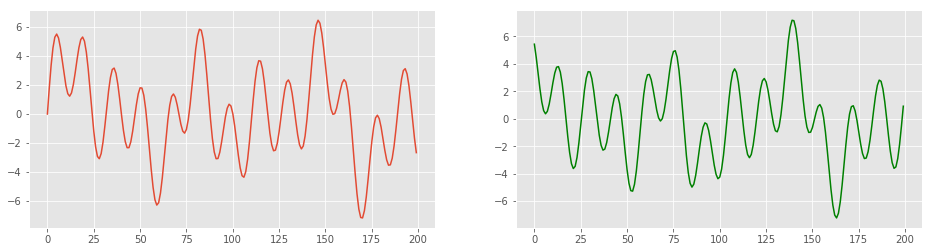

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(train_sequence_2)
ax[1].plot(test_sequence_2, color='green')
plt.show()

In [79]:
train_sequence = train_sequence_1
test_sequence = test_sequence_1

train_sequence = np.reshape(train_sequence, (train_sequence.shape[0], 1))
test_sequence = np.reshape(test_sequence, (test_sequence.shape[0], 1))

In [81]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
min_max_scaler.fit(train_sequence)

scaled_train_sequence = min_max_scaler.transform(train_sequence)
scaled_test_sequence = min_max_scaler.transform(test_sequence)

In [102]:
def samples_and_targets_from_sequence(sequence, window_size):
    """
    Return lists of samples and targets built from overlapping
    windows of the given size. Windows start at the beginning of
    the input sequence and move right by 1 element.
    """
    samples = []
    targets = []
    # i is starting position
    for i in range(sequence.shape[0] - window_size):
        # sub-list of elements
        sample = sequence[i:i+window_size]
        # element following sample
        target = sequence[i+window_size]
        # append sample to list
        samples.append(sample)
        # append target to list
        targets.append(target[0])
        # return as Numpy arrays
    return (np.array(samples), np.array(targets))

In [125]:
window_size = 2
number_of_epochs = 50

(X_train, y_train) = samples_and_targets_from_sequence(scaled_train_sequence, window_size)
(X_test, y_test) = samples_and_targets_from_sequence(scaled_test_sequence, window_size)

In [126]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(3, input_shape=[window_size, 1]))
model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=number_of_epochs, batch_size=1, verbose=1)

Epoch 1/50
198/198 [==============================] - 2s 12ms/step - loss: 0.1974
Epoch 2/50
198/198 [==============================] - 1s 7ms/step - loss: 0.0455
Epoch 3/50
198/198 [==============================] - 1s 6ms/step - loss: 0.0285
Epoch 4/50
198/198 [==============================] - 2s 8ms/step - loss: 0.0178
Epoch 5/50
198/198 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 6/50
198/198 [==============================] - 1s 7ms/step - loss: 0.0050
Epoch 7/50
198/198 [==============================] - 2s 8ms/step - loss: 0.0031
Epoch 8/50
198/198 [==============================] - 2s 8ms/step - loss: 0.0025
Epoch 9/50
198/198 [==============================] - 2s 8ms/step - loss: 0.0024
Epoch 10/50
198/198 [==============================] - 2s 8ms/step - loss: 0.0024
Epoch 11/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0025
Epoch 12/50
198/198 [==============================] - 1s 7ms/step - loss: 0.0024
Epoch 13/50
198/198 [===

Training RMS error: 0.25
Test RMS error: 0.26


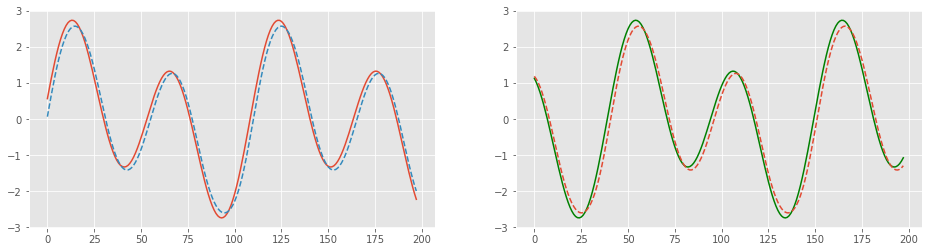

In [132]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

# inverse-transform original targets
inverse_y_train = min_max_scaler.inverse_transform([y_train])
inverse_y_test = min_max_scaler.inverse_transform([y_test])

# inverse-transform predictions
inverse_y_train_predict = min_max_scaler.inverse_transform(y_train_predict)
inverse_y_test_predict = min_max_scaler.inverse_transform(y_test_predict)

scaled_train_sequence = min_max_scaler.transform(train_sequence)
scaled_test_sequence = min_max_scaler.transform(test_sequence)

trainScore = math.sqrt(mean_squared_error(inverse_y_train[0], inverse_y_train_predict[:,0]))
print('Training RMS error: {:.2f}'.format(trainScore))
testScore = math.sqrt(mean_squared_error(inverse_y_test[0], inverse_y_test_predict[:,0]))
print('Test RMS error: {:.2f}'.format(testScore))


fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(inverse_y_train[0])
ax[0].plot(inverse_y_train_predict, linestyle='--')
ax[1].plot(inverse_y_test[0], color='green')
ax[1].plot(inverse_y_test_predict, linestyle='--')
plt.show()

#### Other Sample

In [133]:
train_sequence = train_sequence_2
test_sequence = test_sequence_2

train_sequence = np.reshape(train_sequence, (train_sequence.shape[0], 1))
test_sequence = np.reshape(test_sequence, (test_sequence.shape[0], 1))

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
min_max_scaler.fit(train_sequence)

scaled_train_sequence = min_max_scaler.transform(train_sequence)
scaled_test_sequence = min_max_scaler.transform(test_sequence)

In [140]:
window_size = 2
number_of_epochs = 20

(X_train, y_train) = samples_and_targets_from_sequence(scaled_train_sequence, window_size)
(X_test, y_test) = samples_and_targets_from_sequence(scaled_test_sequence, window_size)

In [142]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(9, return_sequences=True, input_shape=[window_size, 1]))
model.add(LSTM(6, return_sequences=True))
model.add(LSTM(3))
model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=number_of_epochs, 
                    batch_size=1, verbose=1, validation_data=(X_test, y_test), 
                    shuffle=False)

Train on 198 samples, validate on 198 samples
Epoch 1/20
198/198 [==============================] - 8s 42ms/step - loss: 0.1670 - val_loss: 0.0353
Epoch 2/20
198/198 [==============================] - 3s 16ms/step - loss: 0.0387 - val_loss: 0.0298
Epoch 3/20
198/198 [==============================] - 3s 17ms/step - loss: 0.0320 - val_loss: 0.0240
Epoch 4/20
198/198 [==============================] - 4s 19ms/step - loss: 0.0251 - val_loss: 0.0184
Epoch 5/20
198/198 [==============================] - 3s 14ms/step - loss: 0.0194 - val_loss: 0.0145
Epoch 6/20
198/198 [==============================] - 4s 18ms/step - loss: 0.0162 - val_loss: 0.0127
Epoch 7/20
198/198 [==============================] - 4s 21ms/step - loss: 0.0148 - val_loss: 0.0120
Epoch 8/20
198/198 [==============================] - 3s 16ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 9/20
198/198 [==============================] - 3s 15ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 10/20
198/198 [========================

Training RMS error: 0.28
Test RMS error: 0.28


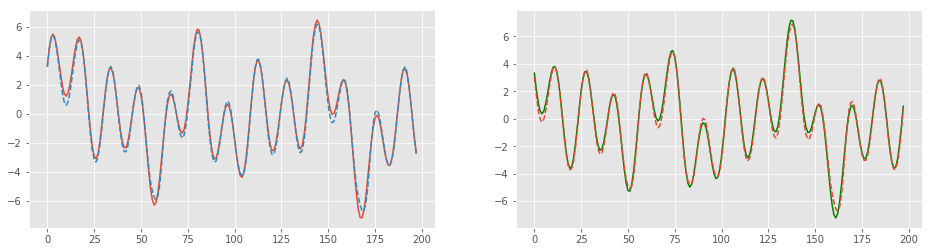

In [136]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

# inverse-transform original targets
inverse_y_train = min_max_scaler.inverse_transform([y_train])
inverse_y_test = min_max_scaler.inverse_transform([y_test])

# inverse-transform predictions
inverse_y_train_predict = min_max_scaler.inverse_transform(y_train_predict)
inverse_y_test_predict = min_max_scaler.inverse_transform(y_test_predict)

scaled_train_sequence = min_max_scaler.transform(train_sequence)
scaled_test_sequence = min_max_scaler.transform(test_sequence)

trainScore = math.sqrt(mean_squared_error(inverse_y_train[0], inverse_y_train_predict[:,0]))
print('Training RMS error: {:.2f}'.format(trainScore))
testScore = math.sqrt(mean_squared_error(inverse_y_test[0], inverse_y_test_predict[:,0]))
print('Test RMS error: {:.2f}'.format(testScore))


fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(inverse_y_train[0])
ax[0].plot(inverse_y_train_predict, linestyle='--')
ax[1].plot(inverse_y_test[0], color='green')
ax[1].plot(inverse_y_test_predict, linestyle='--')
plt.show()

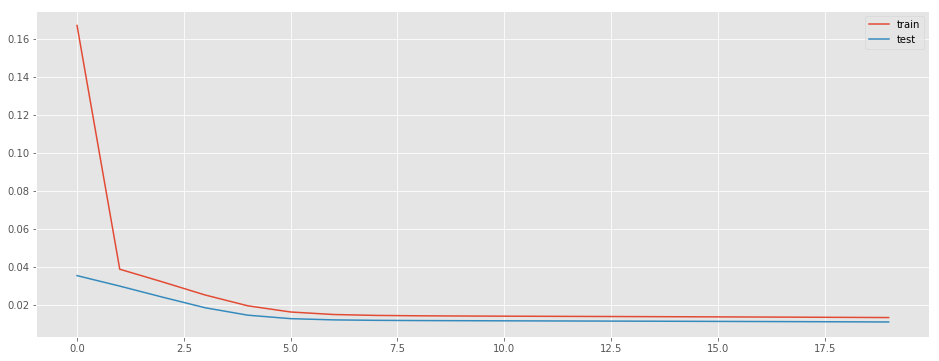

In [143]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()